In [1]:
import warnings
warnings.filterwarnings("ignore")

## Master's Thesis Report: Data Collection and Processing for EEG and Audio Analysis

---

### **1. Introduction**

In the realm of cognitive neuroscience and psychology, the concurrent collection of EEG and audio data provides a rich source of information. This report outlines the methodology and infrastructure employed to collect, store, and process EEG and audio data from participants during an online quiz. The entire system is designed with a focus on user privacy, data integrity, and seamless integration of multiple technologies.

---

### **2. Data Collection**

#### **2.1 Overview**

Participants engage in an online quiz developed using the Angular framework. During this quiz, two primary types of data are collected:

- **EEG Data**: Captured continuously as participants answer questions.
- **Audio Data**: Recorded intermittently after each question, where participants vocalize a predefined sentence.

#### **2.2 Angular Front-end Application**

- The Angular application serves as the primary interface for participants.
- Initially, participants are educated about the quiz mechanics, EEG data collection procedures, and privacy policies.
- Upon agreement, the quiz commences.
- The Angular app is integrated with the **Key Cloak server** for authentication purposes. This server generates a unique UUID for each user, ensuring data anonymity by decoupling personal identification information from the collected data.

#### **2.3 Spring Back-end Server**

- The Spring server interacts with the Angular front-end only if user authentication via Key Cloak is successful.
- It is responsible for storing quiz data, EEG data links, and audio data links.
- Actual EEG and audio blobs are stored in **Firebase**, not in the Spring back-end. Only links to these blobs in Firebase are stored in the Spring server.

#### **2.4 Python Flask Server**

- The Flask server, developed in Python, is tasked with EEG data collection.
- It interfaces directly with the **Brain Access EEG device** using Brain Access's internal libraries.
- Upon receiving a signal from the Angular app (when the user confirms wearing the EEG cap), the Flask server initiates EEG data collection.
- As the participant progresses through the quiz on the Angular app, EEG data is continuously collected by the Flask server.

---

### **3. Data Storage**

#### **3.1 Firebase**

- Firebase serves as the primary storage for raw EEG and audio data blobs.
- Post data collection, the Angular app uploads audio recordings to Firebase and retrieves the corresponding links.
- The Flask server, after concluding EEG data collection, converts the EEG data into a `.fif` format (a standard format used by the MNE Python library for EEG data) and uploads it to Firebase. The link to this file is then sent to the Spring back-end for storage.

#### **3.2 Data Anonymization**

- To ensure user privacy, only UUIDs are stored in the Spring back-end.
- Personal identification data, such as usernames and passwords, reside solely in the Key Cloak server, isolated from other systems.

---

### **4. Data Processing**

#### **4.1 Pre-processing**

- **EEG Data**: After collection, EEG data undergoes several preprocessing steps, including filtering, normalization, and artifact removal, to enhance its quality for subsequent analysis.

- **Audio Data**: Audio recordings are subjected to noise reduction, filtering, normalization, and silence removal to ensure clarity and consistency.

#### **4.2 Post-processing**

- Detailed analysis and feature extraction are performed on the pre-processed data to derive insights, such as stress levels from the audio recordings.

---

### **5. Conclusion**

The infrastructure described herein offers a robust and privacy-centric approach to collecting and processing EEG and audio data. By leveraging multiple technologies and ensuring data anonymization, it provides a reliable foundation for cognitive research and analysis.

### **6. Architecture Diagram**

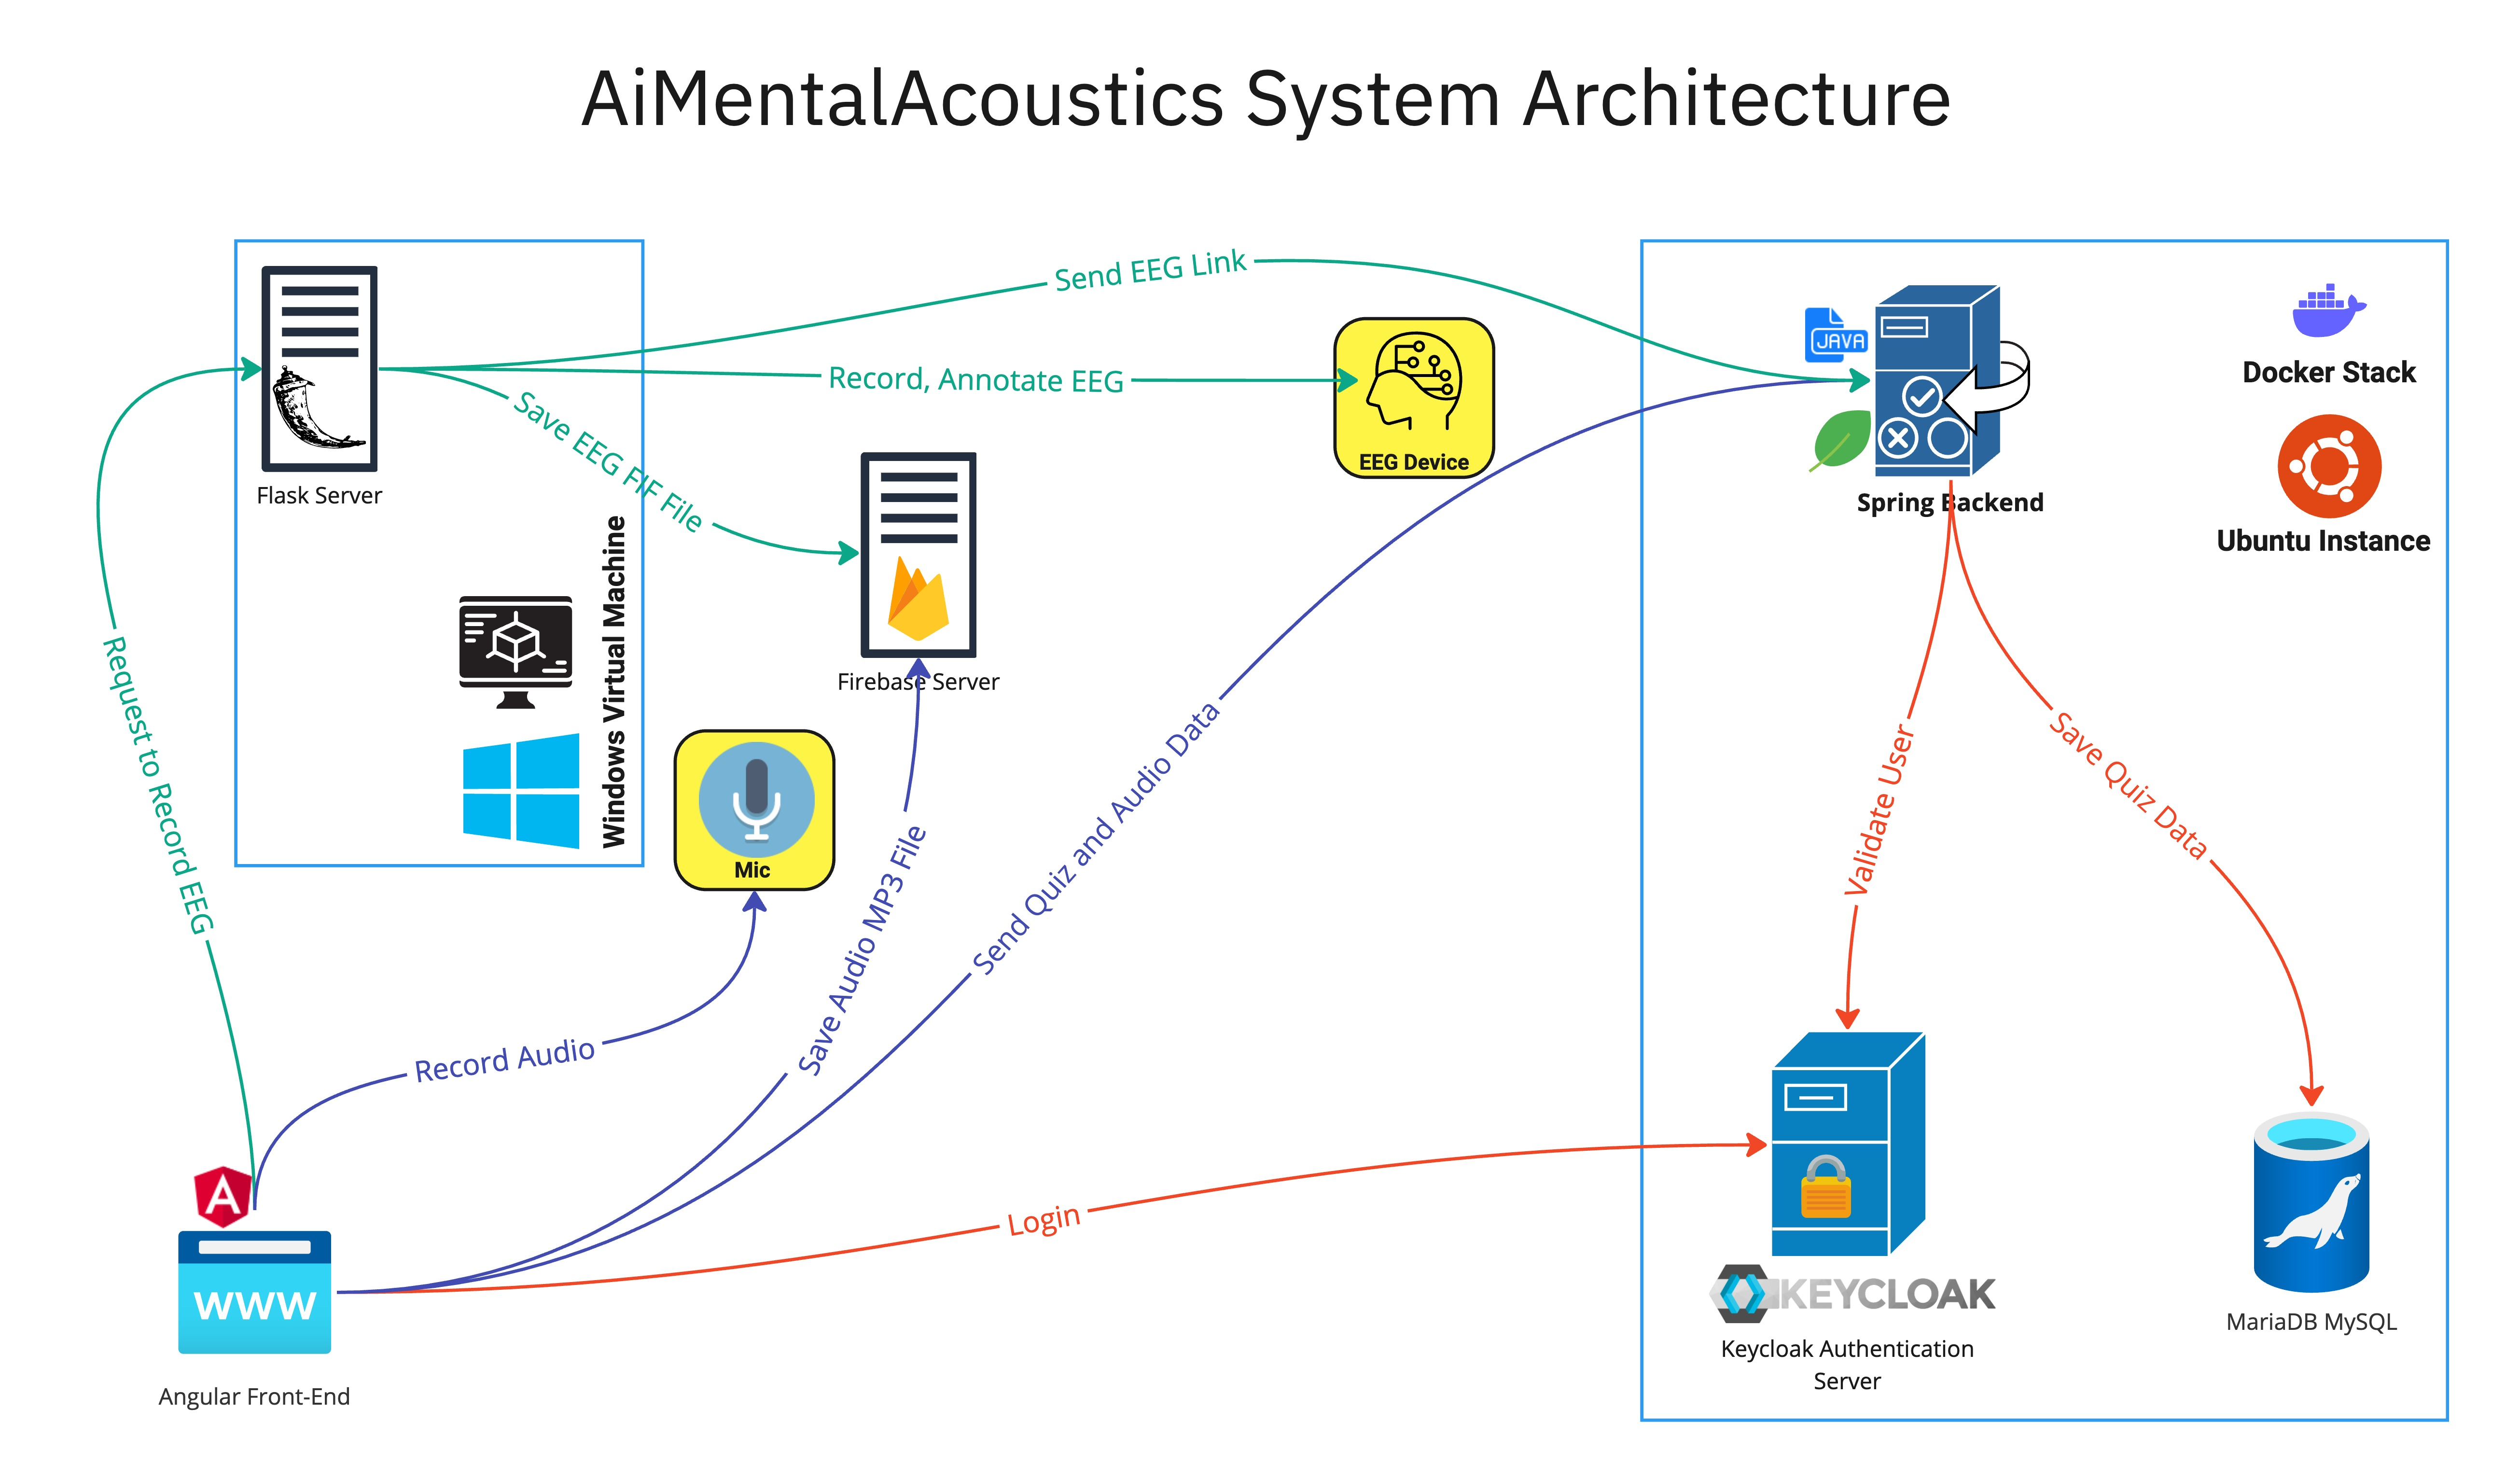

In [2]:
from IPython.display import Image
Image(filename="documents/AiMentalAcousticsArchitecture.jpg", width=1000)

## Data Analysis

The actual code for the aforementioned architecture can be found as follows:
1. [Angular Front-end](https://gitlab.lnu.se/ps222vt/ai-mental-acoustics-quiz/-/tree/main/frontend)
2. [Spring Back-end](https://gitlab.lnu.se/ps222vt/ai-mental-acoustics-quiz/-/tree/main/backend)
3. [Python Flask Server](https://github.com/prasannjeet/brainaccess-eeg-python/blob/main/record_flask.py)

In this report, we will focus on the data analysis part of the project. As we are aware that all the quiz related data is stored in the mysql database of the spring backend, we will first use the spring endpoint to fetch all user data. Note that since the backend is protected with keycloak, we will need to first authenticate ourselves with the backend before we can fetch any data. For this we will use a special client id and secret that we have created for this purpose. The flow will be as follows:

1. Authenticate with keycloak using the client id and secret.
2. Fetch the access token from the response.
3. Use the access token to fetch the user data from the spring backend.

Note that the aforementioned steps are already implemented in the file `fetch_data.py`. We will directly use this file to get all our data. Since spring backend only stores the links to the actual data, we will need to fetch the actual data from firebase. This is also taken care of in the `fetch_data.py` file. The data is store as a blob file which we will import here and use it as required. Note that these files need not be saved locally.

## Utility Functions
The file `utilities.py` contains all the utility functions that we will use in this report. We will import all the functions from this file here.

In [3]:
import io

import matplotlib.pyplot as plt
import mne
import numpy as np
from pydub import AudioSegment
from scipy.io import wavfile
from scipy.signal import spectrogram
import warnings
import time
from IPython.display import display, set_matplotlib_formats

from fetch_data import fetch_first_user_fif_blob, fetch_first_user_audio
from utilities import preprocess_raw_data, add_plot_title

warnings.filterwarnings("ignore")

In [4]:
# Fetch the FIF blob of the first user
fif_blob = fetch_first_user_fif_blob()

# Create a BytesIO object from the blob
fif_buffer = io.BytesIO(fif_blob)

# Read the FIF data from the buffer
raw = mne.io.read_raw_fif(fif_buffer, preload=True)

Opening raw data file <_io.BytesIO object at 0x28d01a480>...
    Range : 0 ... 24774 =      0.000 ...    99.096 secs
Ready.
Reading 0 ... 24774  =      0.000 ...    99.096 secs...


## Preprocessing
At this stage, we have the raw data from the first user. We will now perform some preprocessing steps on this data to make it more suitable for analysis. The preprocessing steps are as follows:

1. Remove Unused Channels: There are some channels in the raw data that are not used, viz. 'Accel_x', `Accel_y`, `Accel_z`, `Digital`, `Sample`. We will remove these channels from the raw data.
2. Next, we will remove the the mean (baseline) from the data.
3. Finally, we will apply a bandpass filter to the data. The bandpass filter will remove all the frequencies that are not in the range of 0.5-30 Hz. This will remove all the noise from the data.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)



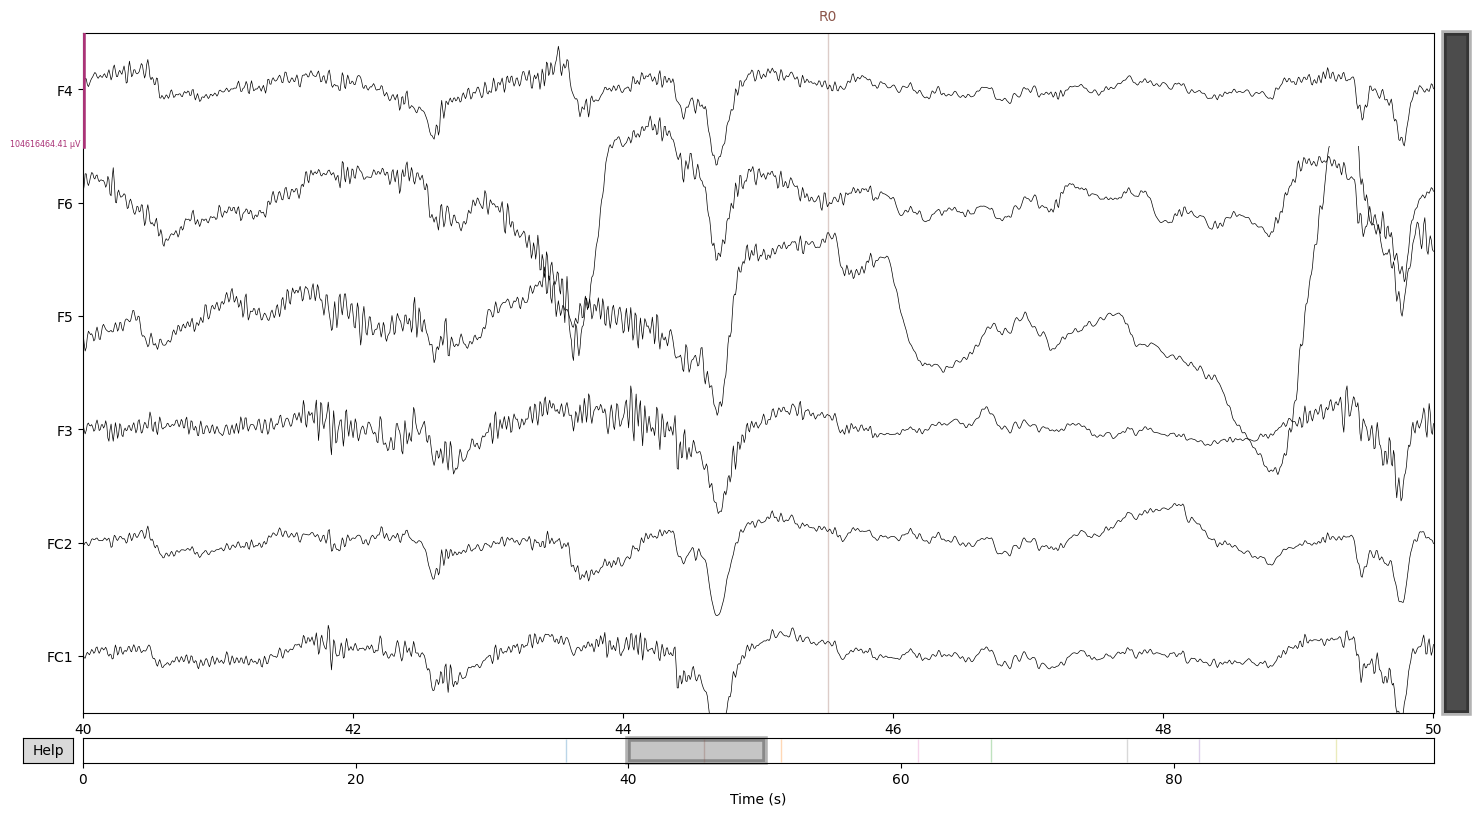

In [5]:
# Preprocess the raw data
raw = preprocess_raw_data(raw)
# Plot the data from 40 to 50 seconds
fig = raw.plot(scalings='auto', verbose=False, duration=10, start=40)
plt.show()

## Visualising EEG and Audio Data

Above is a portion of the complete EEG plot from t = 40 seconds to 50 seconds. However, while recording EEG data, we have appropriately annotated the data at the timestamps when the user goes to a particular question and when the user records audio. Based on the annotations, we will display the EEG data accordingly.

### EEG Data
Let us first visualise only the EEG data based on the questions and answers. Every time the participant is redirected to a quiz, we annotate the EEG data with Qn, where n is the question number, starting from 0. After the participant has answered the question, they are redirected to the recording page, at that point, we annotate the EEG data with Rn, where n is the answer number, starting from 0. The following function will plot the EEG data based on the annotations. We plot the data from Q0 to R0, Q1 to R1, and so on.

In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

Found a pair: Q0 & R0
Found a pair: Q1 & R1
Found a pair: Q2 & R2
Found a pair: Q3 & R3
Found 4 pairs of quiz and audio recordings. Dividing the plot into 4 parts and displaying each plot separately.
Plotting segment 0: 35.411999 to 45.515999
Used Annotations descriptions: ['R0']


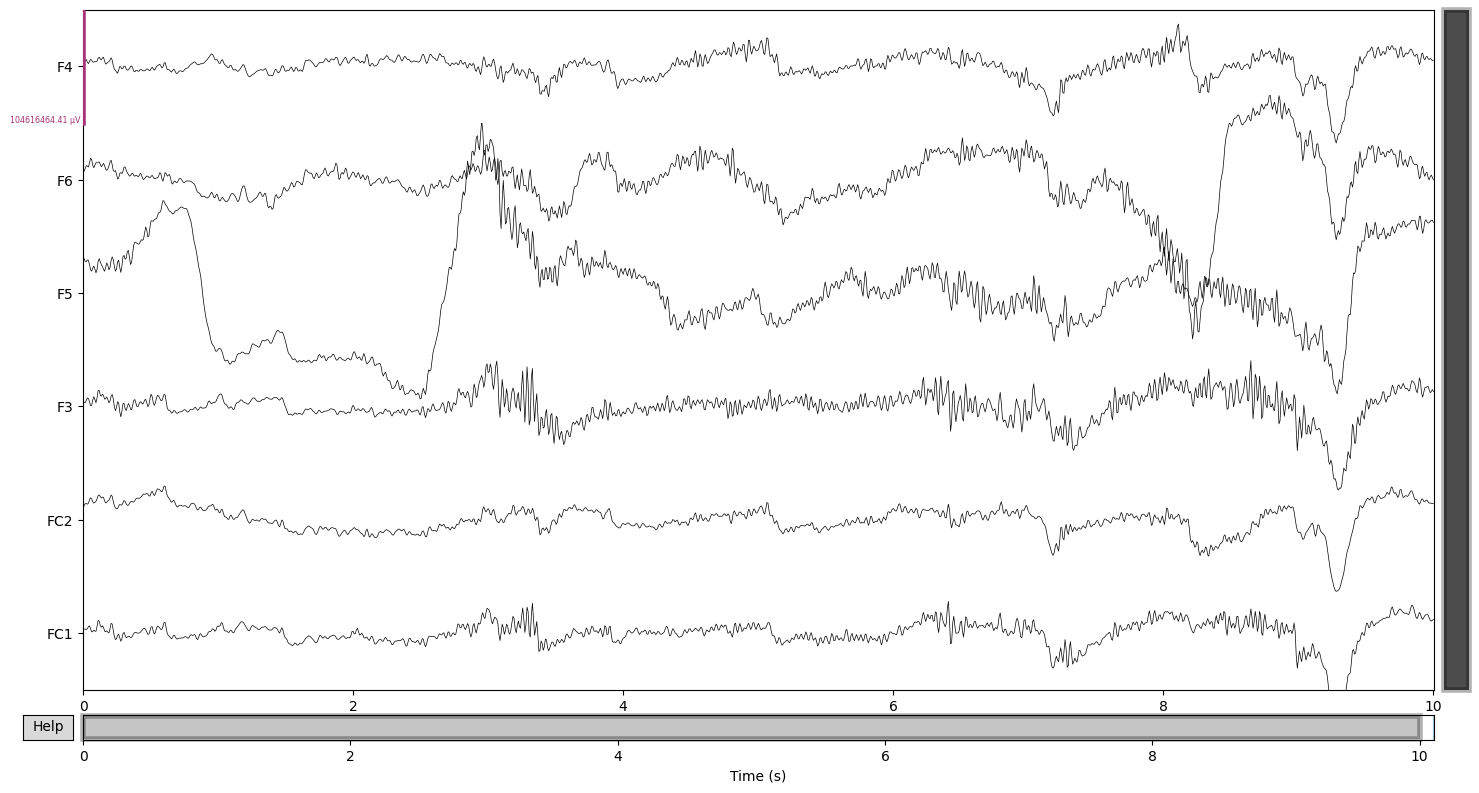

Plotting segment 1: 51.172001 to 61.264
Used Annotations descriptions: ['Q1', 'R1']


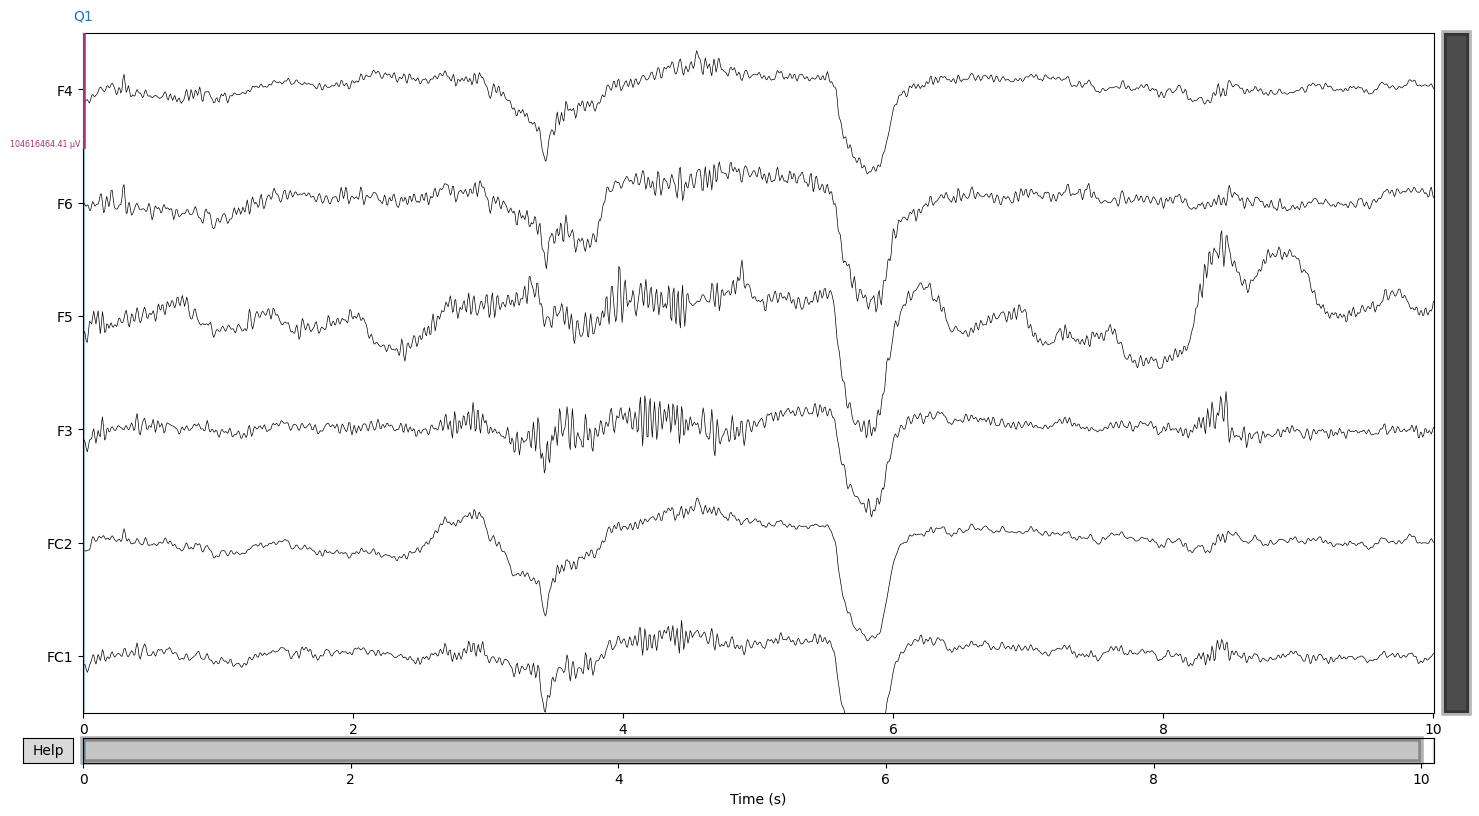

Plotting segment 2: 66.584 to 76.603996
Used Annotations descriptions: ['Q2', 'R2']


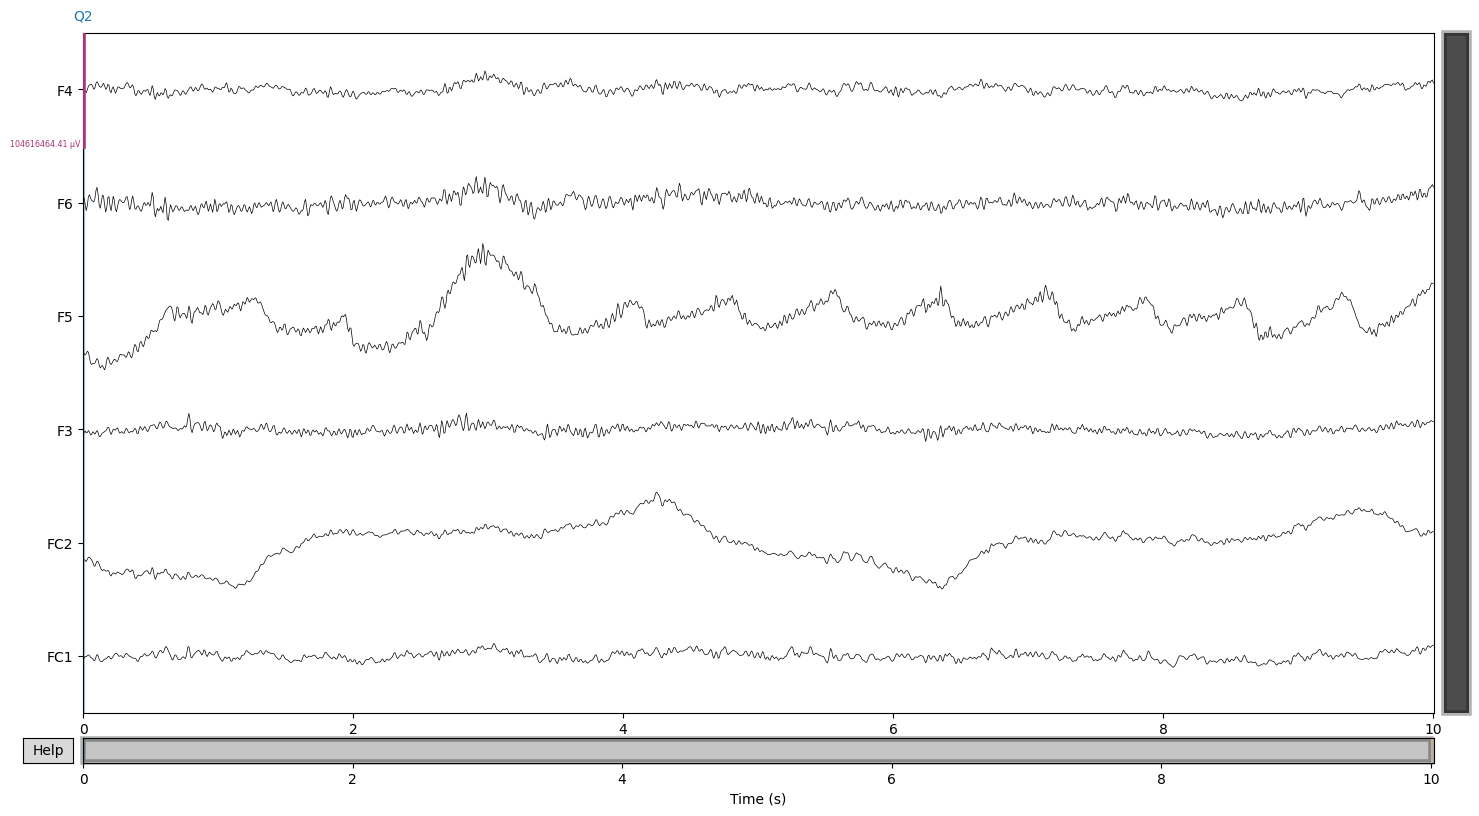

Plotting segment 3: 81.888 to 91.940002
Used Annotations descriptions: ['Q3', 'R3']


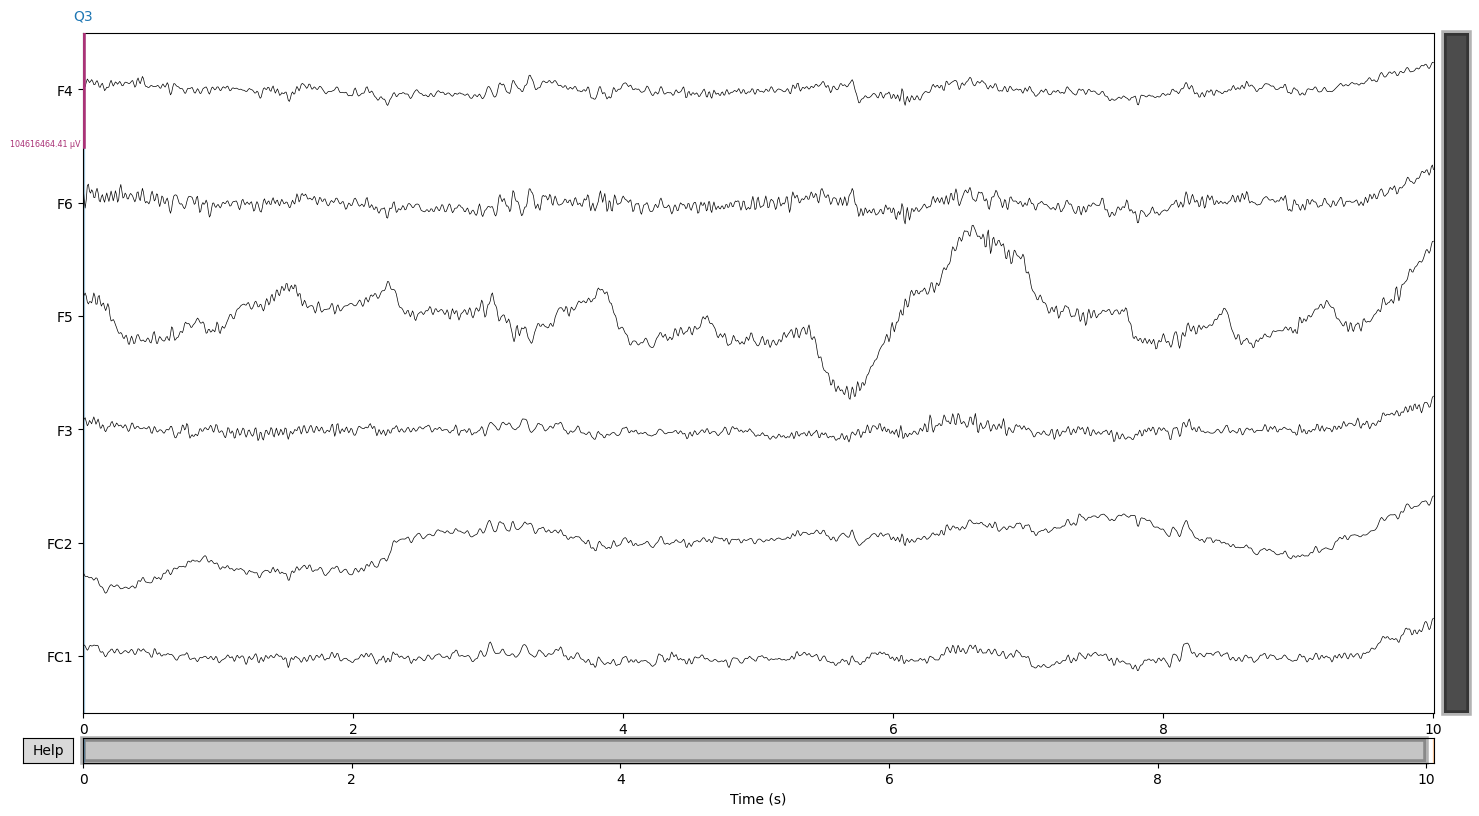

In [7]:
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (10, 6)  # Set the default figure size. You can adjust this as per requirements.
# set_matplotlib_formats('svg')  # Display figures in SVG format. This can be 'png', 'retina', etc.



# We use the same scaling as the one auto-generated when we plot the raw data. After manually trying various scaling parameters, it was found that the auto-generated scaling is the best.
scaling_after_auto = fig.mne.scalings

# Extract the annotations
annotations = raw.annotations

# Find the Q and R annotations and their timestamps
q_r_pairs = []
for i, description in enumerate(annotations.description):
    if description.startswith('Q'):
        q_time = annotations.onset[i]  # Get the onset time of the Q annotation
        r_description = 'R' + description[1:]
        r_times = annotations.onset[annotations.description == r_description]
        if len(r_times) > 0:
            r_time = r_times[0]  # Get the onset time of the corresponding R annotation
            q_r_pairs.append((q_time, r_time))  # Store the onset times as a pair
            print(f"Found a pair: {description} & {r_description}")

# Print the number of pairs found
print(
    f"Found {len(q_r_pairs)} pairs of quiz and audio recordings. Dividing the plot into {len(q_r_pairs)} parts and displaying each plot separately.")

raw_segment_array = []

# Plot the segments between Q and R annotations
for i, (q_time, r_time) in enumerate(q_r_pairs):
    print(f"Plotting segment {i}: {q_time} to {r_time}")
    # Crop the data to the desired segment using the onset times of the Q and R annotations
    raw_segment = raw.copy().crop(tmin=q_time, tmax=r_time).load_data()
    raw_segment_array.append(raw_segment)

    events, event_id = mne.events_from_annotations(raw_segment)
    fig = raw_segment.plot(scalings=scaling_after_auto, verbose=False, title=f"Segment {i}: {q_time} to {r_time}")
    add_plot_title(f"Graph for Question {i + 1}", fig)

    plt.show()

    time.sleep(0.5)